In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')
dataset_path="/content/drive/My Drive/Dataset/vegie-cleaned"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(dataset_path)
for klass in classlist:
    classpath=os.path.join(dataset_path,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths    labels
0  /content/drive/My Drive/Dataset/vegie-cleaned/...  Broccoli
1  /content/drive/My Drive/Dataset/vegie-cleaned/...  Broccoli
2  /content/drive/My Drive/Dataset/vegie-cleaned/...  Broccoli
3  /content/drive/My Drive/Dataset/vegie-cleaned/...  Broccoli
4  /content/drive/My Drive/Dataset/vegie-cleaned/...  Broccoli
labels
Broccoli    400
Carrot      400
Potato      400
Capsicum    400
Name: count, dtype: int64


In [ ]:
# prompt: print urutan kelas yang benar

print(df['labels'].value_counts().index.tolist())

['Broccoli', 'Carrot', 'Potato', 'Capsicum']


# CNN RESNET

In [ ]:
# prompt: dengan dataset yang telah di augnmentasi saya ingin melakukan klasifikasi menggunakan algoritma CNN Resnet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Preprocessing
IMG_WIDTH = 224  # Adjust as needed based on your dataset
IMG_HEIGHT = 224 # Adjust as needed based on your dataset
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32  # Adjust as needed

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Image data generators with augmentation for training data only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Important for multi-class
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Important for multi-class
)


# ResNet Model
def create_resnet_model(input_shape, num_classes):
    base_model = keras.applications.ResNet50(
        weights='imagenet',  # or None if you want to train from scratch
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False # initially freeze layers

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    return model

# Define number of classes
num_classes = len(df['labels'].unique())

# Create and compile the model
model = create_resnet_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy for multi-class
              metrics=['accuracy'])

# Train the model
EPOCHS = 25 # adjust as needed
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Fine-tuning (optional)
# Unfreeze some layers in the base model and retrain with a lower learning rate
# base_model.trainable = True
# for layer in base_model.layers[:100]: # adjust the number of layers to unfreeze
#     layer.trainable = False
# model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the model (after training and optional fine-tuning)
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# CNN (Standard) CNN Conv2D

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Preprocessing
IMG_WIDTH = 224  # Adjust as needed based on your dataset
IMG_HEIGHT = 224 # Adjust as needed based on your dataset
image_size = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32  # Adjust as needed

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Image data generators with augmentation for training data only
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # Important for multi-class
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=image_size,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Important for multi-class
)


In [ ]:
# prompt: lakukan modelling menggunakan CNN 2d dengan epoch 25, dan batch size 32

# CNN Model (Conv2D)
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Add dropout for regularization
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define number of classes
num_classes = len(df['labels'].unique())

# Create and compile the CNN model
cnn_model = create_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes)
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
EPOCHS = 25
BATCH_SIZE = 32
cnn_history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_generator
)

# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"CNN Test Loss: {loss}")
print(f"CNN Test Accuracy: {accuracy}")

Epoch 1/25
40/40 [==============================] - 366s 9s/step - loss: 1.4038 - accuracy: 0.3703 - val_loss: 0.9491 - val_accuracy: 0.5156
Epoch 2/25
40/40 [==============================] - 112s 3s/step - loss: 0.9532 - accuracy: 0.5234 - val_loss: 0.8151 - val_accuracy: 0.5656
Epoch 3/25
40/40 [==============================] - 112s 3s/step - loss: 0.8245 - accuracy: 0.5992 - val_loss: 0.8670 - val_accuracy: 0.6156
Epoch 4/25
40/40 [==============================] - 111s 3s/step - loss: 0.7617 - accuracy: 0.6352 - val_loss: 0.6705 - val_accuracy: 0.6875
Epoch 5/25
40/40 [==============================] - 111s 3s/step - loss: 0.7376 - accuracy: 0.6781 - val_loss: 0.6549 - val_accuracy: 0.7344
Epoch 6/25
40/40 [==============================] - 111s 3s/step - loss: 0.7734 - accuracy: 0.6625 - val_loss: 0.6638 - val_accuracy: 0.7469
Epoch 7/25
40/40 [==============================] - 112s 3s/step - loss: 0.7100 - accuracy: 0.6781 - val_loss: 0.8044 - val_accuracy: 0.7094
Epoch 8/25
40

In [ ]:
# prompt: simpan model resnet dan cnn yang telah di run

# Save the ResNet model
# model.save('/content/drive/My Drive/Tubes_PCD/resnet_model.h5')

# Save the CNN model
cnn_model.save('/content/drive/My Drive/Model/cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Manual Prediction


Predictions using CNN model:


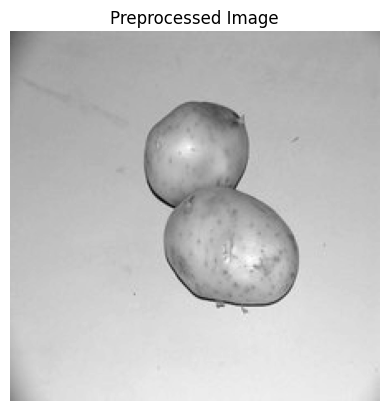

1/1 [==============================] - 0s 36ms/step
Predicted class: Potato
Class probabilities:
Broccoli: 1.05%
Capsicum: 8.29%
Carrot: 19.63%
Potato: 71.03%


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define constants for image size (adjust based on model input requirements)
IMG_WIDTH = 224  # Replace with the required width
IMG_HEIGHT = 224  # Replace with the required height

def preprocess_image_manual(image_path):
    # Load the image
    img = cv2.imread(image_path)  # Load image in BGR format
    if img is None:
        raise ValueError("Image not found or path is incorrect")

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image
    resized_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    # Normalize the image
    normalized_img = resized_img / 255.0

    # Add channel dimension for grayscale
    preprocessed_img = np.stack([normalized_img, normalized_img, normalized_img], axis=-1) # Modification here

    # Expand dimensions to fit the model input shape
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension

    # Display the preprocessed image
    plt.imshow(normalized_img, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')
    plt.show()

    return preprocessed_img

def predict_image_manual(image_path, model, class_labels):
    # Preprocess the image
    preprocessed_img = preprocess_image_manual(image_path)

    # Predict the class probabilities
    classes = model.predict(preprocessed_img, batch_size=1)

    # Convert probabilities to percentages
    percentages = classes[0] * 100

    # Get the predicted class index
    predicted_class = np.argmax(classes)

    predicted_label = class_labels[predicted_class]

    print(f"Predicted class: {predicted_label}")
    print("Class probabilities:")
    for label, percentage in zip(class_labels, percentages):
        print(f"{label}: {percentage:.2f}%")

# Example usage (replace with your image path and class labels)
image_path_to_predict = "/content/drive/MyDrive/Dataset/Vegetables-Raw/Potato/0131.jpg"  # Update with the path to your image

# Define class labels (replace with your actual labels)
class_labels_resnet = ['Broccoli', 'Capsicum', 'Carrot', 'Potato']  # Replace with ResNet class labels
class_labels_cnn = ['Broccoli', 'Capsicum', 'Carrot', 'Potato']    # Replace with CNN class labels

# Predict using "model"
# print("Predictions using ResNet model:")
# predict_image_manual(image_path_to_predict, model, class_labels_resnet)

# Predict using "cnn_model"
print("\nPredictions using CNN model:")
predict_image_manual(image_path_to_predict, cnn_model, class_labels_cnn)


# Prediksi dengan Cara lain

In [ ]:
# import numpy as np
# from tensorflow.keras.preprocessing import image

# def predict_image(image_path, model):
#     img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
#     x = x / 255.0  # Normalize the image

#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=32)

#     # Convert probabilities to percentages
#     percentages = classes[0] * 100

#     predicted_class = np.argmax(classes)

#     # Get class labels from the generator (assuming you have them)
#     class_labels = list(train_generator.class_indices.keys())

#     predicted_label = class_labels[predicted_class]

#     print(f"Predicted class: {predicted_label}")
#     print("Class probabilities:")
#     for label, percentage in zip(class_labels, percentages):
#         print(f"{label}: {percentage:.2f}%")

# # Example usage (replace with your image path and chosen model)
# image_path_to_predict = "/content/potato.jpg"  # Update with the path to your image

# # Choose which model to use for prediction
# predict_image(image_path_to_predict, model)  # ResNet model
# # OR
# # predict_image(image_path_to_predict, cnn_model)  # CNN model


In [ ]:
# prompt: print lah nama file random dari dataset pada masing masing kelas

import random

# Assuming df is your DataFrame with 'filepaths' and 'labels' columns
# and classlist contains the class names

for klass in classlist:
  class_files = df[df['labels'] == klass]['filepaths'].tolist()
  if class_files:  # Check if there are any files for this class
    random_file = random.choice(class_files)
    print(f"Class: {klass}, Random file: {random_file}")
  else:
    print(f"Class: {klass} has no files in the dataset")

Class: Potato, Random file: /content/drive/MyDrive/Dataset/Augmented_Dataset/Potato/0047_hflip_1.jpg
Class: Capsicum, Random file: /content/drive/MyDrive/Dataset/Augmented_Dataset/Capsicum/0076_hflip_1.jpg
Class: Carrot, Random file: /content/drive/MyDrive/Dataset/Augmented_Dataset/Carrot/0003_zoom_3.jpg
Class: Broccoli, Random file: /content/drive/MyDrive/Dataset/Augmented_Dataset/Broccoli/0065_zoom_3.jpg
